## Analyse du système minimal en 1.5D avec denavit hartenberg, pour valider méthodo.

<div>
<img src="../Pictures/SchemaModeleJeuxTolerance.png" width="750"/>
</div>

In [1]:
import os
import pickle
import re
import pprint
import numpy as np
import sympy as sp
import scipy
import openturns as ot
import matplotlib.pyplot as plt
import trimesh as tr

from math import pi
from joblib import Parallel, delayed
from importlib import reload
from IPython.display import display, clear_output, HTML, IFrame
from time import time, sleep
from sympy.printing import latex
from trimesh import viewer as trview
from scipy.optimize import OptimizeResult, minimize, Bounds, LinearConstraint, basinhopping, differential_evolution, brute

from efficient_kan import KAN, KANLinear

import otaf

I4 = otaf.I4()
J4 = otaf.J4()

#### **Définition des grandeurs nominales de la pièce**

In [2]:
### Different measures of our problem
X1 = 99.8  # Nominal Length of the male piece
X2 = 100.0  # Nominal Length of the female piece
X3 = 10.0  # Nominal width of the pieces
j = X2 - X1  # Nominal play between pieces.
T = 0.2 * np.sqrt(2)  # Tolerance for X1 and X2. (95% conform)  (= t/2)
t_ = T / 2

#### **Définition du repère global R0 / qui est aussi un repère local de la pièce fixe.**

In [3]:
R0 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
x_, y_, z_ = R0[0], R0[1], R0[2]

#### **Définition des coordonnées des points charactéristiques de chaque surface de chaque pièce.**

In [4]:
# Pièce 1 (male)
P1A0, P1A1, P1A2 = (
    np.array((0, X3 / 2, 0.0)),
    np.array((0, X3, 0.0)),
    np.array((0, 0, 0.0)),
)
P1B0, P1B1, P1B2 = (
    np.array((X1, X3 / 2, 0.0)),
    np.array((X1, X3, 0.0)),
    np.array((X1, 0, 0.0)),
)
P1C0, P1C1, P1C2 = (
    np.array((X1 / 2, 0, 0.0)),
    np.array((0, 0, 0.0)),
    np.array((X1, 0, 0.0)),
)

# Pièce 2 (femelle)  # On met les points à hM et pas hF pour qu'ils soient bien opposées! (Besoin??)
P2A0, P2A1, P2A2 = (
    np.array((0, X3 / 2, 0.0)),
    np.array((0, X3, 0.0)),
    np.array((0, 0, 0.0)),
)
P2B0, P2B1, P2B2 = (
    np.array((X2, X3 / 2, 0.0)),
    np.array((X2, X3, 0.0)),
    np.array((X2, 0, 0.0)),
)
P2C0, P2C1, P2C2 = (
    np.array((X2 / 2, 0, 0.0)),
    np.array((0, 0, 0.0)),
    np.array((X2, 0, 0.0)),
)

#### **Définisson les repères locaux de chaque surface substituée.**

In [5]:
# Pièce1
RP1a = np.array([-1 * x_, -1 * y_, z_])
RP1b = R0
RP1c = np.array([-y_, x_, z_])

# Pièce2
RP2a = R0
RP2b = np.array([-1 * x_, -1 * y_, z_])
RP2c = np.array([y_, -1 * x_, z_])

#### **Maintenant construisons les matrices de transformation pour passer du repère global aux repères locaux (et de définition des matrices de déviation et Jeu! )**
- tfrt : transformation from rotation translation

In [6]:
TP1aA0, TP1aA1, TP1aA2 = (
    otaf.geometry.tfrt(RP1a, P1A0),
    otaf.geometry.tfrt(RP1a, P1A1),
    otaf.geometry.tfrt(RP1a, P1A2),
)
TP1bB0, TP1bB1, TP1bB2 = (
    otaf.geometry.tfrt(RP1b, P1B0),
    otaf.geometry.tfrt(RP1b, P1B1),
    otaf.geometry.tfrt(RP1b, P1B2),
)
TP1cC0, TP1cC1, TP1cC2 = (
    otaf.geometry.tfrt(RP1c, P1C0),
    otaf.geometry.tfrt(RP1c, P1C1),
    otaf.geometry.tfrt(RP1c, P1C2),
)

TP2aA0, TP2aA1, TP2aA2 = (
    otaf.geometry.tfrt(RP2a, P2A0),
    otaf.geometry.tfrt(RP2a, P2A1),
    otaf.geometry.tfrt(RP2a, P2A2),
)
TP2bB0, TP2bB1, TP2bB2 = (
    otaf.geometry.tfrt(RP2b, P2B0),
    otaf.geometry.tfrt(RP2b, P2B1),
    otaf.geometry.tfrt(RP2b, P2B2),
)
TP2cC0, TP2cC1, TP2cC2 = (
    otaf.geometry.tfrt(RP2c, P2C0),
    otaf.geometry.tfrt(RP2c, P2C1),
    otaf.geometry.tfrt(RP2c, P2C2),
)

In [7]:
# Transformation matrices dictionary
TMD = {}
TMD["T1c1a"] = otaf.TransformationMatrix(initial=TP1cC0, final=TP1aA0)
TMD["T2a2c"] = otaf.TransformationMatrix(initial=TP2aA0, final=TP2cC0)
TMD["T1c1b"] = otaf.TransformationMatrix(initial=TP1cC0, final=TP1bB0)
TMD["T2b2c"] = otaf.TransformationMatrix(initial=TP2bB0, final=TP2cC0)

TMD["TP1aA1aA0"] = otaf.TransformationMatrix(initial=TP1aA1, final=TP1aA0)
TMD["TP2aA0aA1"] = otaf.TransformationMatrix(initial=TP2aA0, final=TP2aA1)
TMD["TP1aA2aA0"] = otaf.TransformationMatrix(initial=TP1aA2, final=TP1aA0)
TMD["TP2aA0aA2"] = otaf.TransformationMatrix(initial=TP2aA0, final=TP2aA2)

TMD["TP1bB1bB0"] = otaf.TransformationMatrix(initial=TP1bB1, final=TP1bB0)
TMD["TP2bB0bB1"] = otaf.TransformationMatrix(initial=TP2bB0, final=TP2bB1)
TMD["TP1bB2bB0"] = otaf.TransformationMatrix(initial=TP1bB2, final=TP1bB0)
TMD["TP2bB0bB2"] = otaf.TransformationMatrix(initial=TP2bB0, final=TP2bB2)

In [8]:
# Deviation matrix with no defects
DI4 = otaf.DeviationMatrix(index=-1, translations="", rotations="")  # Pas de défauts

### **Construction des boucles pour les équations de compatibilité.** 

Pour ce système simple, seulement deux boucles sont nécessaires.

##### **Boucle de compatibilibté 1 : 2c -> 1c -> 1a -> 2a**

D2c2c -> GP2cC0P1cC0 -> J4 -> D1c1c -> T1c1a -> D1a1a -> GP1aA0P2aA0 -> J4 -> D2a2a -> T2a2c

In [9]:
# Définissons les matrices :
D2c2c = D1c1c = D1a1a = D2a2a = DI4  # Pas de défauts

# GAP 0, contact plan-plan, contact bloqué par minimisation
GP2cC0P1cC0 = otaf.GapMatrix(index=0, translations_blocked="z", rotations_blocked="xy")
# GAP 1, contact plan-plan, tran x et rot z
GP1aA0P2aA0 = otaf.GapMatrix(index=1, translations_blocked="z", rotations_blocked="xy")

expa_1 = otaf.FirstOrderMatrixExpansion(
    [
        D2c2c,
        GP2cC0P1cC0,
        J4,
        D1c1c,
        TMD["T1c1a"],
        D1a1a,
        GP1aA0P2aA0,
        J4,
        D2a2a,
        TMD["T2a2c"],
    ]
).compute_first_order_expansion()
expa_1

Matrix([
[                    1, -gamma_g_0 - gamma_g_1, 0, -gamma_g_0/10 - 50*gamma_g_1 + u_g_0 + v_g_1],
[gamma_g_0 + gamma_g_1,                      1, 0,           5*gamma_g_1 - u_g_1 + v_g_0 + 1/10],
[                    0,                      0, 1,                                            0],
[                    0,                      0, 0,                                            1]])

##### **Boucle  de compatibilibté 2 : 2c -> 1c -> 1b -> 2b**

D2c2c -> GP2cC0P1cC0 -> J4 -> D1c1c -> T1c1b -> D1b1b -> GP1bB0P2bB0 -> J4 -> D2b2b -> T2b2c

In [10]:
# Définissons les matrices :   # D2c2c -> GP2cC0P1cC0 -> D1c1c ->
D1b1b = otaf.DeviationMatrix(index=1, translations="x", rotations="z")  # Défauts plan
GP1bB0P2bB0 = otaf.GapMatrix(
    index=2, translations_blocked="z", rotations_blocked="xy"
)  # GAP 2, jeu plan
D2b2b = otaf.DeviationMatrix(
    index=2, translations="x", rotations="z", inverse=True
)  # Défauts plan #

expa_2 = otaf.FirstOrderMatrixExpansion(
    [
        D2c2c,
        GP2cC0P1cC0,
        J4,
        D1c1c,
        TMD["T1c1b"],
        D1b1b,
        GP1bB0P2bB0,
        J4,
        D2b2b,
        TMD["T2b2c"],
    ]
).compute_first_order_expansion()
expa_2

Matrix([
[                                            1, -gamma_d_1 + gamma_d_2 - gamma_g_0 - gamma_g_2, 0,      50*gamma_d_1 - 50*gamma_d_2 + gamma_g_0/10 + 50*gamma_g_2 + u_g_0 - v_g_2],
[gamma_d_1 - gamma_d_2 + gamma_g_0 + gamma_g_2,                                              1, 0, 5*gamma_d_1 - 5*gamma_d_2 + 5*gamma_g_2 + u_d_1 + u_d_2 + u_g_2 + v_g_0 - 1/10],
[                                            0,                                              0, 1,                                                                              0],
[                                            0,                                              0, 0,                                                                              1]])

In [11]:
    expr_compa_1 = otaf.common.get_relevant_expressions(expa_1)
    expr_compa_2 = otaf.common.get_relevant_expressions(expa_2)

compatibility_expressions = [*expr_compa_1, *expr_compa_2]

### **Définition et expression des contraintes d'interface**

##### **Boucle d'interface 1 côté A :**

In [12]:
# GP1aA1P2aA1 = TP1aA1aA0 GP1aA0P2aA0 J4 TP2aA0aA1 J4
expa_f_1 = otaf.FirstOrderMatrixExpansion(
    [TMD["TP1aA1aA0"], GP1aA0P2aA0, J4, TMD["TP2aA0aA1"], J4]
).compute_first_order_expansion()
expa_f_1

Matrix([
[        1, -gamma_g_1, 0, 5*gamma_g_1 + u_g_1],
[gamma_g_1,          1, 0,               v_g_1],
[        0,          0, 1,                   0],
[        0,          0, 0,                   1]])

In [13]:
# GP1aA2P2aA2 = TP1aA2aA0 GP1aA0P2aA0 J4 TP2aA0aA2 J4
expa_f_2 = otaf.FirstOrderMatrixExpansion(
    [TMD["TP1aA2aA0"], GP1aA0P2aA0, J4, TMD["TP2aA0aA2"], J4]
).compute_first_order_expansion()
expa_f_2

Matrix([
[        1, -gamma_g_1, 0, -5*gamma_g_1 + u_g_1],
[gamma_g_1,          1, 0,                v_g_1],
[        0,          0, 1,                    0],
[        0,          0, 0,                    1]])

##### **Boucle d'interface 2 côté B :**

In [14]:
# GP1bB1P2bB1 = TP1bB1bB0 GP1bB0P2bB0 J4 TP2bB0bB1 J4
expa_f_3 = otaf.FirstOrderMatrixExpansion(
    [TMD["TP1bB1bB0"], GP1bB0P2bB0, J4, TMD["TP2bB0bB1"], J4]
).compute_first_order_expansion()
expa_f_3

Matrix([
[        1, -gamma_g_2, 0, -5*gamma_g_2 + u_g_2],
[gamma_g_2,          1, 0,                v_g_2],
[        0,          0, 1,                    0],
[        0,          0, 0,                    1]])

In [15]:
# GP1bB2P2bB2 = TP1bB2bB0 GP1bB0P2bB0 J4 TP2bB0bB2 J4
expa_f_4 = otaf.FirstOrderMatrixExpansion(
    [TMD["TP1bB2bB0"], GP1bB0P2bB0, J4, TMD["TP2bB0bB2"], J4]
).compute_first_order_expansion()
expa_f_4

Matrix([
[        1, -gamma_g_2, 0, 5*gamma_g_2 + u_g_2],
[gamma_g_2,          1, 0,               v_g_2],
[        0,          0, 1,                   0],
[        0,          0, 0,                   1]])

In [16]:
mask_matrix = sp.Matrix(
    np.array([[0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
)  # Only translation u should be positive
expa_f_1 = expa_f_1.multiply_elementwise(mask_matrix)
expa_f_2 = expa_f_2.multiply_elementwise(mask_matrix)
expa_f_3 = expa_f_3.multiply_elementwise(mask_matrix)
expa_f_4 = expa_f_4.multiply_elementwise(mask_matrix)

In [17]:
expr_fonc_1 = otaf.common.get_relevant_expressions(expa_f_1)
expr_fonc_2 = otaf.common.get_relevant_expressions(expa_f_2)
expr_fonc_3 = otaf.common.get_relevant_expressions(expa_f_3)
expr_fonc_4 = otaf.common.get_relevant_expressions(expa_f_4)

interface_constraints = [*expr_fonc_1, *expr_fonc_2, *expr_fonc_3, *expr_fonc_4]

In [18]:
print("Compatibility equations:")
for i in range(len(compatibility_expressions)):
    display(compatibility_expressions[i])

print("Interface equations:")
for i in range(len(interface_constraints)):
    display(interface_constraints[i])

Compatibility equations:


-gamma_g_0 - gamma_g_1

-gamma_g_0/10 - 50*gamma_g_1 + u_g_0 + v_g_1

5*gamma_g_1 - u_g_1 + v_g_0 + 1/10

-gamma_d_1 + gamma_d_2 - gamma_g_0 - gamma_g_2

50*gamma_d_1 - 50*gamma_d_2 + gamma_g_0/10 + 50*gamma_g_2 + u_g_0 - v_g_2

5*gamma_d_1 - 5*gamma_d_2 + 5*gamma_g_2 + u_d_1 + u_d_2 + u_g_2 + v_g_0 - 1/10

Interface equations:


5*gamma_g_1 + u_g_1

-5*gamma_g_1 + u_g_1

-5*gamma_g_2 + u_g_2

5*gamma_g_2 + u_g_2

In [19]:
SOCAM = otaf.SystemOfConstraintsAssemblyModel(
    compatibility_expressions, interface_constraints, verbose=2
)

SOCAM.embedOptimizationVariable()

C_opt = np.array([0, 1, 0, 0, 1, 0, 0, 0, 0])  # None
print(SOCAM.deviation_symbols)
print(SOCAM.gap_symbols)

[u_d_1, gamma_d_1, u_d_2, gamma_d_2]
[u_g_0, v_g_0, gamma_g_0, u_g_1, v_g_1, gamma_g_1, u_g_2, v_g_2, gamma_g_2, s]


In [20]:
# D'abord les variances des lois si leur influence était unique (et nous a environ 95% de conformité)
T = 0.2 *np.sqrt(2)  # Tolerance for X1 and X2. (95% conform)  (= t/2)
t_ = T / 2
Cm = 1
sigma_e_pos = T / (6 * Cm)

# Le défaut en orientation est piloté par une incertitude sur un angle. On suppose les angles petits << 1 rad
theta_max = T / X3
sigma_e_theta = (2*theta_max) / (6*Cm) 

In [21]:
# Let's make our random vector With openturns
RandDeviationVect = otaf.uncertainty.get_composed_normal_defect_distribution(
    defect_names=SOCAM.deviation_symbols,
    sigma_dict = {"alpha":sigma_e_theta, 
                  "beta":sigma_e_theta,
                  "gamma":sigma_e_theta, 
                  "u":sigma_e_pos, 
                  "v":sigma_e_pos, 
                  "w":sigma_e_pos})

RandDeviationVect

Index,Variable,Distribution
0,u_d_1,"Normal(mu = 0, sigma = 0.0471405)"
1,gamma_d_1,"Normal(mu = 0, sigma = 0.00942809)"
2,u_d_2,"Normal(mu = 0, sigma = 0.0471405)"
3,gamma_d_2,"Normal(mu = 0, sigma = 0.00942809)"


### Some deep learning interlude

$$f(x) = \frac{1}{e^{3 \cdot \left( e^{\frac{x}{|x| + 0.04}} -1 \right)}}$$

In [22]:
desmos_figure = '<iframe src="https://www.desmos.com/calculator/68wxkdal59?embed" width="500" height="500" style="border: 1px solid #ccc" frameborder=0></iframe>'
display(HTML(desmos_figure))

/home/ksimady/anaconda3/envs/anr-dev/lib/python3.11/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [23]:

# Define the seed, sample size, and file paths
SEED = 42  # Example seed value
sample_size = 100000
model_name = "model1.5d"
sample_filename = f'STORAGE/training_sample_{sample_size}_seed_{SEED}_{model_name}_ai.npy'
results_filename = f'STORAGE/training_results_{sample_size}_seed_{SEED}_{model_name}_ai.npy'

# Ensure reproducibility by setting the seed
np.random.seed(SEED)

# Check if the sample and results files already exist
if os.path.exists(sample_filename) and os.path.exists(results_filename):
    with open(sample_filename, 'rb') as file:
        TRAIN_SAMPLE = np.load(file)
    with open(results_filename, 'rb') as file:
        TRAIN_RESULTS = np.load(file)
    print("Loaded existing sample and results from file.")
else:
    # Generate the sample
    dist = otaf.uncertainty.multiply_composed_distribution_with_constant(
        RandDeviationVect, 1.15) # We now work with low failure probabilities
    #TRAIN_SAMPLE = np.array(otaf.uncertainty.generateLHSExperiment(dist, sample_size))
    TRAIN_SAMPLE = np.array(dist.getSample(sample_size),dtype="float32")
    # Compute the results
    TRAIN_RESULTS = otaf.uncertainty.compute_gap_optimizations_on_sample_batch(
        SOCAM,
        TRAIN_SAMPLE,
        bounds=None,
        n_cpu=-2,
        progress_bar=True,
        batch_size=500,
        dtype="float32"
    )
    #TRAIN_RESULTS = np.array([res.x[-1] for res in TRAIN_RESULTS],dtype="float32") #Only s variable.
    
    # Save the sample and results
    with open(sample_filename, 'wb') as file:
        np.save(file, TRAIN_SAMPLE)
    with open(results_filename, 'wb') as file:
        np.save(file, TRAIN_RESULTS)
    print("Generated and saved new sample and results with seed.")

# Assign X and y from TRAIN_SAMPLE and TRAIN_RESULTS
Xtrain = TRAIN_SAMPLE
ytrain = TRAIN_RESULTS
print(f"Ratio of failed simulations in sample : {np.where(ytrain[:,-1]<0,1,0).sum()/sample_size}")

Using s variable for objective


  0%|          | 0/100000 [00:00<?, ?it/s]

Generated and saved new sample and results with seed.
Ratio of failed simulations in sample : 0.0646


[4, 22, 12, 5, 1]
[4, 22, 12, 5, 1]


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 001, Val Loss: 1.052577, Val R2: -699.755188


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 002, Val Loss: 1.026038, Val R2: -1229.215698


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 003, Val Loss: 1.005237, Val R2: -1872.398071


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 004, Val Loss: 0.987424, Val R2: -2139.757812


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 005, Val Loss: 0.972307, Val R2: -1546.094727


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 006, Val Loss: 0.958179, Val R2: -889.369019


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 007, Val Loss: 0.942557, Val R2: -504.871552


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 008, Val Loss: 0.924015, Val R2: -298.217438


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 009, Val Loss: 0.902012, Val R2: -183.170624


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 010, Val Loss: 0.876476, Val R2: -115.923187


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 011, Val Loss: 0.847407, Val R2: -74.937996


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 012, Val Loss: 0.814870, Val R2: -49.184223


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 013, Val Loss: 0.779047, Val R2: -32.627625


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 014, Val Loss: 0.739613, Val R2: -21.770618


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 015, Val Loss: 0.695912, Val R2: -14.483418


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 016, Val Loss: 0.647627, Val R2: -9.499660


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 017, Val Loss: 0.594891, Val R2: -6.069576


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 018, Val Loss: 0.538432, Val R2: -3.717684


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 019, Val Loss: 0.479446, Val R2: -2.117423


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 020, Val Loss: 0.419661, Val R2: -1.040009


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 021, Val Loss: 0.361392, Val R2: -0.325003


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 022, Val Loss: 0.307585, Val R2: 0.139820


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 023, Val Loss: 0.261656, Val R2: 0.433388


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 024, Val Loss: 0.226746, Val R2: 0.611810


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 025, Val Loss: 0.204467, Val R2: 0.715204


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 026, Val Loss: 0.193201, Val R2: 0.772454


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 027, Val Loss: 0.187441, Val R2: 0.804171


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 028, Val Loss: 0.180103, Val R2: 0.823998


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 029, Val Loss: 0.166639, Val R2: 0.839570


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 030, Val Loss: 0.147252, Val R2: 0.853732


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 031, Val Loss: 0.126071, Val R2: 0.866068


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 032, Val Loss: 0.108308, Val R2: 0.874772


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 033, Val Loss: 0.095499, Val R2: 0.880668


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 034, Val Loss: 0.085822, Val R2: 0.887116


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 035, Val Loss: 0.076691, Val R2: 0.897350


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 036, Val Loss: 0.066587, Val R2: 0.912220


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 037, Val Loss: 0.056266, Val R2: 0.928808


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 038, Val Loss: 0.046931, Val R2: 0.943890


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 039, Val Loss: 0.039141, Val R2: 0.955954


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 040, Val Loss: 0.033319, Val R2: 0.964453


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 041, Val Loss: 0.029062, Val R2: 0.970156


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 042, Val Loss: 0.025808, Val R2: 0.974041


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 043, Val Loss: 0.023304, Val R2: 0.976707


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 044, Val Loss: 0.021283, Val R2: 0.978673


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 045, Val Loss: 0.019760, Val R2: 0.980076


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 046, Val Loss: 0.018613, Val R2: 0.981116


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 047, Val Loss: 0.017749, Val R2: 0.981944


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 048, Val Loss: 0.017051, Val R2: 0.982707


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 049, Val Loss: 0.016390, Val R2: 0.983498


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 050, Val Loss: 0.015745, Val R2: 0.984259


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 051, Val Loss: 0.015099, Val R2: 0.984960


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 052, Val Loss: 0.014530, Val R2: 0.985527


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 053, Val Loss: 0.014056, Val R2: 0.985961


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 054, Val Loss: 0.013680, Val R2: 0.986269


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 055, Val Loss: 0.013336, Val R2: 0.986527


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 056, Val Loss: 0.013001, Val R2: 0.986789


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 057, Val Loss: 0.012679, Val R2: 0.987074


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 058, Val Loss: 0.012399, Val R2: 0.987346


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 059, Val Loss: 0.012152, Val R2: 0.987596


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 060, Val Loss: 0.011913, Val R2: 0.987844


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 061, Val Loss: 0.011664, Val R2: 0.988112


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 062, Val Loss: 0.011420, Val R2: 0.988379


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 063, Val Loss: 0.011196, Val R2: 0.988623


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 064, Val Loss: 0.010990, Val R2: 0.988847


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 065, Val Loss: 0.010791, Val R2: 0.989071


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 066, Val Loss: 0.010596, Val R2: 0.989290


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 067, Val Loss: 0.010407, Val R2: 0.989495


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 068, Val Loss: 0.010225, Val R2: 0.989685


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 069, Val Loss: 0.010048, Val R2: 0.989865


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 070, Val Loss: 0.009876, Val R2: 0.990035


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 071, Val Loss: 0.009710, Val R2: 0.990195


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 072, Val Loss: 0.009548, Val R2: 0.990354


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 073, Val Loss: 0.009387, Val R2: 0.990517


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 074, Val Loss: 0.009230, Val R2: 0.990679


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 075, Val Loss: 0.009077, Val R2: 0.990838


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 076, Val Loss: 0.008927, Val R2: 0.990994


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 077, Val Loss: 0.008778, Val R2: 0.991147


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 078, Val Loss: 0.008633, Val R2: 0.991291


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 079, Val Loss: 0.008491, Val R2: 0.991429


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 080, Val Loss: 0.008352, Val R2: 0.991565


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 081, Val Loss: 0.008214, Val R2: 0.991702


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 082, Val Loss: 0.008079, Val R2: 0.991838


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 083, Val Loss: 0.007945, Val R2: 0.991977


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 084, Val Loss: 0.007811, Val R2: 0.992117


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 085, Val Loss: 0.007679, Val R2: 0.992254


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 086, Val Loss: 0.007550, Val R2: 0.992388


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 087, Val Loss: 0.007422, Val R2: 0.992518


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 088, Val Loss: 0.007297, Val R2: 0.992644


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 089, Val Loss: 0.007174, Val R2: 0.992768


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 090, Val Loss: 0.007052, Val R2: 0.992890


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 091, Val Loss: 0.006932, Val R2: 0.993012


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 092, Val Loss: 0.006813, Val R2: 0.993133


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 093, Val Loss: 0.006695, Val R2: 0.993254


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 094, Val Loss: 0.006579, Val R2: 0.993372


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 095, Val Loss: 0.006464, Val R2: 0.993489


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 096, Val Loss: 0.006351, Val R2: 0.993603


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 097, Val Loss: 0.006240, Val R2: 0.993716


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 098, Val Loss: 0.006129, Val R2: 0.993827


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 099, Val Loss: 0.006020, Val R2: 0.993938


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 100, Val Loss: 0.005912, Val R2: 0.994047


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 101, Val Loss: 0.005805, Val R2: 0.994156


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 102, Val Loss: 0.005699, Val R2: 0.994263


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 103, Val Loss: 0.005594, Val R2: 0.994370


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 104, Val Loss: 0.005490, Val R2: 0.994476


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 105, Val Loss: 0.005386, Val R2: 0.994581


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 106, Val Loss: 0.005283, Val R2: 0.994685


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 107, Val Loss: 0.005180, Val R2: 0.994789


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 108, Val Loss: 0.005077, Val R2: 0.994893


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 109, Val Loss: 0.004975, Val R2: 0.994997


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 110, Val Loss: 0.004872, Val R2: 0.995101


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 111, Val Loss: 0.004770, Val R2: 0.995203


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 112, Val Loss: 0.004669, Val R2: 0.995306


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 113, Val Loss: 0.004568, Val R2: 0.995407


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 114, Val Loss: 0.004468, Val R2: 0.995508


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 115, Val Loss: 0.004369, Val R2: 0.995607


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 116, Val Loss: 0.004270, Val R2: 0.995706


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 117, Val Loss: 0.004172, Val R2: 0.995804


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 118, Val Loss: 0.004076, Val R2: 0.995902


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 119, Val Loss: 0.003981, Val R2: 0.995997


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 120, Val Loss: 0.003889, Val R2: 0.996091


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 121, Val Loss: 0.003799, Val R2: 0.996182


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 122, Val Loss: 0.003712, Val R2: 0.996270


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 123, Val Loss: 0.003627, Val R2: 0.996356


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 124, Val Loss: 0.003545, Val R2: 0.996439


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 125, Val Loss: 0.003466, Val R2: 0.996520


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 126, Val Loss: 0.003388, Val R2: 0.996598


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 127, Val Loss: 0.003313, Val R2: 0.996674


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 128, Val Loss: 0.003240, Val R2: 0.996749


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 129, Val Loss: 0.003168, Val R2: 0.996821


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 130, Val Loss: 0.003099, Val R2: 0.996891


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 131, Val Loss: 0.003032, Val R2: 0.996958


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 132, Val Loss: 0.002967, Val R2: 0.997024


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 133, Val Loss: 0.002903, Val R2: 0.997088


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 134, Val Loss: 0.002841, Val R2: 0.997151


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 135, Val Loss: 0.002781, Val R2: 0.997211


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 136, Val Loss: 0.002723, Val R2: 0.997270


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 137, Val Loss: 0.002666, Val R2: 0.997328


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 138, Val Loss: 0.002611, Val R2: 0.997383


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 139, Val Loss: 0.002558, Val R2: 0.997437


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 140, Val Loss: 0.002506, Val R2: 0.997489


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 141, Val Loss: 0.002456, Val R2: 0.997539


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 142, Val Loss: 0.002407, Val R2: 0.997588


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 143, Val Loss: 0.002360, Val R2: 0.997635


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 144, Val Loss: 0.002314, Val R2: 0.997682


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 145, Val Loss: 0.002270, Val R2: 0.997726


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 146, Val Loss: 0.002227, Val R2: 0.997769


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 147, Val Loss: 0.002186, Val R2: 0.997811


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 148, Val Loss: 0.002146, Val R2: 0.997852


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 149, Val Loss: 0.002107, Val R2: 0.997891


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 150, Val Loss: 0.002070, Val R2: 0.997928


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 151, Val Loss: 0.002033, Val R2: 0.997965


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 152, Val Loss: 0.001998, Val R2: 0.998001


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 153, Val Loss: 0.001963, Val R2: 0.998036


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 154, Val Loss: 0.001930, Val R2: 0.998070


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 155, Val Loss: 0.001897, Val R2: 0.998102


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 156, Val Loss: 0.001865, Val R2: 0.998134


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 157, Val Loss: 0.001834, Val R2: 0.998165


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 158, Val Loss: 0.001804, Val R2: 0.998196


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 159, Val Loss: 0.001774, Val R2: 0.998226


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 160, Val Loss: 0.001745, Val R2: 0.998255


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 161, Val Loss: 0.001717, Val R2: 0.998283


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 162, Val Loss: 0.001689, Val R2: 0.998311


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 163, Val Loss: 0.001662, Val R2: 0.998338


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 164, Val Loss: 0.001635, Val R2: 0.998365


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 165, Val Loss: 0.001610, Val R2: 0.998391


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 166, Val Loss: 0.001584, Val R2: 0.998416


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 167, Val Loss: 0.001560, Val R2: 0.998441


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 168, Val Loss: 0.001536, Val R2: 0.998465


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 169, Val Loss: 0.001512, Val R2: 0.998489


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 170, Val Loss: 0.001489, Val R2: 0.998512


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 171, Val Loss: 0.001466, Val R2: 0.998535


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 172, Val Loss: 0.001444, Val R2: 0.998557


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 173, Val Loss: 0.001423, Val R2: 0.998578


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 174, Val Loss: 0.001401, Val R2: 0.998600


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 175, Val Loss: 0.001381, Val R2: 0.998620


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 176, Val Loss: 0.001361, Val R2: 0.998641


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 177, Val Loss: 0.001341, Val R2: 0.998661


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 178, Val Loss: 0.001321, Val R2: 0.998680


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 179, Val Loss: 0.001302, Val R2: 0.998699


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 180, Val Loss: 0.001284, Val R2: 0.998718


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 181, Val Loss: 0.001265, Val R2: 0.998736


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 182, Val Loss: 0.001248, Val R2: 0.998754


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 183, Val Loss: 0.001230, Val R2: 0.998771


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 184, Val Loss: 0.001213, Val R2: 0.998789


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 185, Val Loss: 0.001196, Val R2: 0.998805


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 186, Val Loss: 0.001180, Val R2: 0.998822


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 187, Val Loss: 0.001164, Val R2: 0.998838


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 188, Val Loss: 0.001148, Val R2: 0.998854


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 189, Val Loss: 0.001133, Val R2: 0.998869


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 190, Val Loss: 0.001118, Val R2: 0.998884


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 191, Val Loss: 0.001103, Val R2: 0.998899


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 192, Val Loss: 0.001088, Val R2: 0.998913


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 193, Val Loss: 0.001074, Val R2: 0.998928


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 194, Val Loss: 0.001060, Val R2: 0.998942


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 195, Val Loss: 0.001047, Val R2: 0.998955


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 196, Val Loss: 0.001033, Val R2: 0.998969


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 197, Val Loss: 0.001020, Val R2: 0.998982


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 198, Val Loss: 0.001007, Val R2: 0.998995


  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 199, Val Loss: 0.000995, Val R2: 0.999007
Stopping: R2 score is high enough.
Finished training at epoch 199 with best loss 0.000995 and R2 of 0.999007


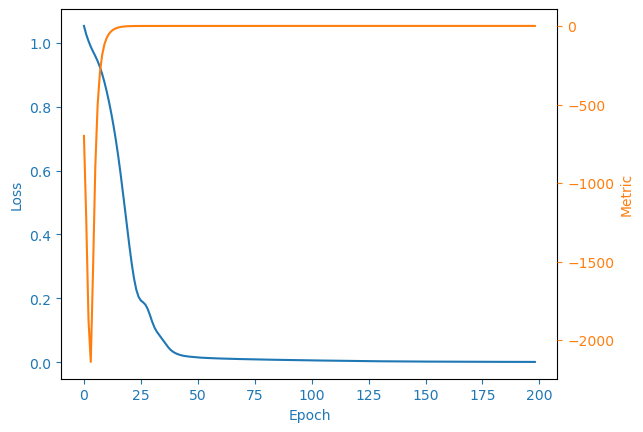

In [24]:
save_path = 'STORAGE/AI_MODEL_1.5D_DIM4.pth'
load = False
dim = int(RandDeviationVect.getDimension())
neural_model = otaf.surrogate.NeuralRegressorNetwork(
    dim, 1,
    Xtrain, ytrain[:,-1], 
    clamping=True, 
    finish_critertion_epoch=5,
    loss_finish=1e-6, 
    metric_finish=0.999, 
    max_epochs=200, 
    batch_size=30000, 
    compile_model=False, 
    train_size=0.6, 
    save_path = save_path,
    input_description=RandDeviationVect.getDescription(),
    display_progress_disable=False)

lr=0.003

neural_model.model = otaf.surrogate.get_base_relu_mlp_model(dim, 1, False)

neural_model.optimizer = otaf.torch.optim.AdamW(neural_model.parameters(), lr=lr, weight_decay=1e-4)
otaf.surrogate.initialize_model_weights(neural_model)
neural_model.scheduler =  otaf.torch.optim.lr_scheduler.ExponentialLR(neural_model.optimizer, 1.0001)
neural_model.loss_fn = otaf.torch.nn.MSELoss()
#neural_model.loss_fn = otaf.uncertainty.LimitSpaceFocusedLoss(0.0001, 2, square=True) # otaf.uncertainty.PositiveLimitSpaceFocusedLoss(0.0001, 2, 4, square=False)

if os.path.exists(save_path) and load:
    neural_model.load_model()
else :
    neural_model.train_model()
    neural_model.plot_results()
    neural_model.save_model()

- Clamping = True
    - R2 with MSE = 0.989309
    - R2 with LimitSpaceFocusedLoss(0.0001, 2, square=True) = 0.85885
    - R2 with LimitSpaceFocusedLoss(0.0001, 2, square=False) = 0.772992
    - R2 with LimitSpaceFocusedLoss(0.00001, 1.55, square=True) = 0.961802
    - R2 with PositiveLimitSpaceFocusedLoss(0.00001, 1.55, 3, square=True)) = 0.909175

- Clamping = False
    - R2 with MSE = 0.967931
    - R2 with LimitSpaceFocusedLoss(0.0001, 2, square=True) = 0.959862
    - R2 with LimitSpaceFocusedLoss(0.0001, 2, square=False) = 0.892209
    - R2 with LimitSpaceFocusedLoss(0.00001, 1.55, square=True) = 0.975688
    - R2 with PositiveLimitSpaceFocusedLoss(0.00001, 1.55, 3, square=True)) = 0.859898
    - R2 with PositiveLimitSpaceFocusedLoss(0.0001, 2, 4 square=False) =  0.897341

In [25]:
def neural_model_size_param_optimizer_function(X, Xtrain=Xtrain, ytrain=ytrain):
    # Function to use with scipy optimize to find best model shape.
    neural_model = otaf.uncertainty.NeuralRegressorNetwork(
        len(SOCAM.deviation_symbols), 
        Xtrain, ytrain, 
        clamping=False, 
        finish_critertion_epoch=150,
        mse_finish_tol=1e-6, 
        grad_finish_tol=1e-3, 
        max_epochs=150, 
        batch_size=1000, 
        lr=0.0005,
        compile_model=False, 
        train_size=0.5, 
        display_progress_disable=True)
    #neural_model.init_model_relu()
    neural_model.model = neural_model.construct_variable_size_sequential_linear_model(
        relative_max_layer_size = X[0],
        relative_max_layer_depth = X[1], 
        relative_layer_number = X[2]
    )
    #neural_model.loss_fn = otaf.uncertainty.LimitSpaceFocusedLoss(0.0001, 2, square=True)
    #neural_model.loss_fn = otaf.uncertainty.PositiveLimitSpaceFocusedLoss(0.0001, 2, 4, square=False)
    neural_model.weights_init_uniform_rule()
    neural_model.init_optimizer()
    neural_model.train()
    R2 = neural_model.best_R2
    return -1/(1-1*R2) # We want to maximize R2 (so minimize -R2)

In [26]:
def opt_callback(xk):
    print(f"Opt params are : {xk.round(4)}")
#neur_mini_res = minimize(
#    neural_model_size_param_optimizer_function, 
#    [4.2314, 3/7, 2/5], 
#    (Xtrain, ytrain,), 
#    bounds=((2., 8.),(1/10, 9/10), (1/5, 2.)), 
#    callback=opt_callback,
#    options={"disp":True, "maxiter":150, "ftol":1e-5,"finite_diff_rel_step":0.2, "eps":1e-1},  )

if False :
    neur_mini_res = differential_evolution(
        neural_model_size_param_optimizer_function, 
        ((2., 8.),(1/10, 9/10), (1/5, 2.)),
        (Xtrain, ytrain,),
        x0 = [4.2314, 3/7, 2/5], #worst_5p_lambda[-4]**2,
        disp=True,
        init="latinhypercube",
        polish=False,
        tol=0.1,
        recombination=0.7,
        maxiter=500,
        strategy='best1bin')
    display(neur_mini_res)

# Calculating probability of failure in the whole imprecise space

### Using the neural network surrogate model

In [42]:
# Let's first generate a classic LHS design of expezriment of size 16.
D_lambd = len(SOCAM.deviation_symbols)
lambda_vect_unconditioned = ot.ComposedDistribution([ot.Uniform(0, 1)] * D_lambd)
lambda_vect_unconditioned.setDescription(list(map(str, SOCAM.deviation_symbols)))
N_lambda = 800
lambda_sample_unconditioned = otaf.uncertainty.generateLHSExperiment(lambda_vect_unconditioned ,N_lambda, 999)
#lambda_sample_unconditioned = lambda_sample_unconditioned_generator.generate()
lambda_sample_random = lambda_vect_unconditioned.getSample(N_lambda)
lambda_sample_conditioned = otaf.uncertainty.condition_lambda_sample(lambda_sample_random, squared_sum=True)
print(", ".join(map(str, SOCAM.gap_symbols)))
print("\n")
print(", ".join(map(str, SOCAM.deviation_symbols)))

u_g_0, v_g_0, gamma_g_0, u_g_1, v_g_1, gamma_g_1, u_g_2, v_g_2, gamma_g_2, s


u_d_1, gamma_d_1, u_d_2, gamma_d_2


#### Calculating over surrogate model

In [44]:
bounds = None
SIZE_MC_PF = int(1e7) #1e4
failure_probabilities = []

start_time = time()  # Record the start time
for i in range(N_lambda):
    print(f"Doing iteration {i+1:03d} of {N_lambda}")
    if i>0:
        print(f"Failure probability {failure_probabilities[i-1]:.3E}, Min: {min(failure_probabilities):.3E}, / Max: {max(failure_probabilities):.3E}")
    composed_dist = otaf.uncertainty.multiply_composed_distribution_standard_with_constants(
        RandDeviationVect, 
        lambda_sample_conditioned[i])
    pf = neural_model.pf_monte_carlo_bruteforce(composed_dist,
            N_MC_MAX=int(1e9),
            N_GEN_MAX=int(1e7),
            batch_size=1000000,
            PF_STAB=1e-7,
            threshold=0.0,)
    failure_probabilities.append(pf)
    clear_output(wait=True)
print(f"Done {len (lambda_sample_conditioned)} experiments.")
print(f"Elapsed time: {time() - start_time:.3f} seconds.")

X = otaf.uncertainty.find_best_worst_quantile(np.array(lambda_sample_conditioned)**2, np.array(failure_probabilities), 0.1)
(best_5p_lambda, best_5p_res), (worst_5p_lambda, worst_5p_res) = X

Done 800 experiments.
Elapsed time: 425.786 seconds.


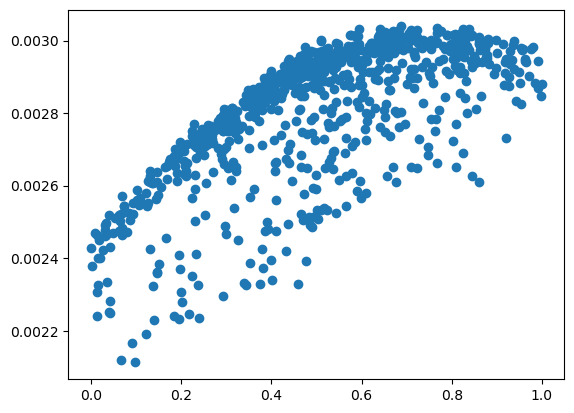

In [46]:
plt.plot((np.array(lambda_sample_conditioned)**2)[:,1], failure_probabilities, 'o')

Lower probability of failure: 0.2112 %
Upper probability of failure: 0.3039 %


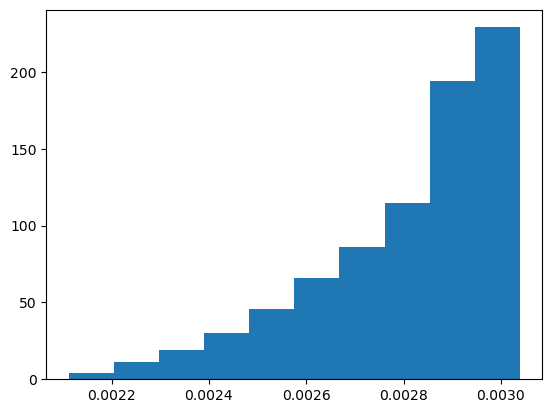

In [47]:
print("Lower probability of failure:", round(min(failure_probabilities) * 100, 4), "%")
print("Upper probability of failure:", round(max(failure_probabilities) * 100, 4), "%")
plt.hist(failure_probabilities)
plt.show()

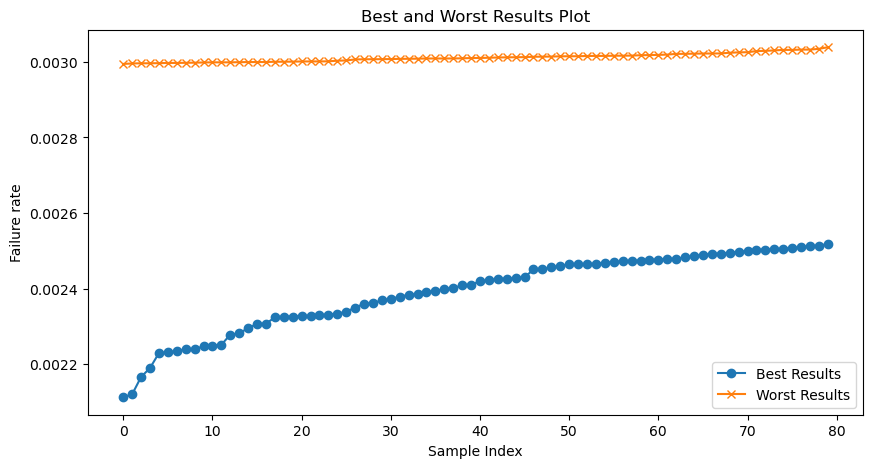

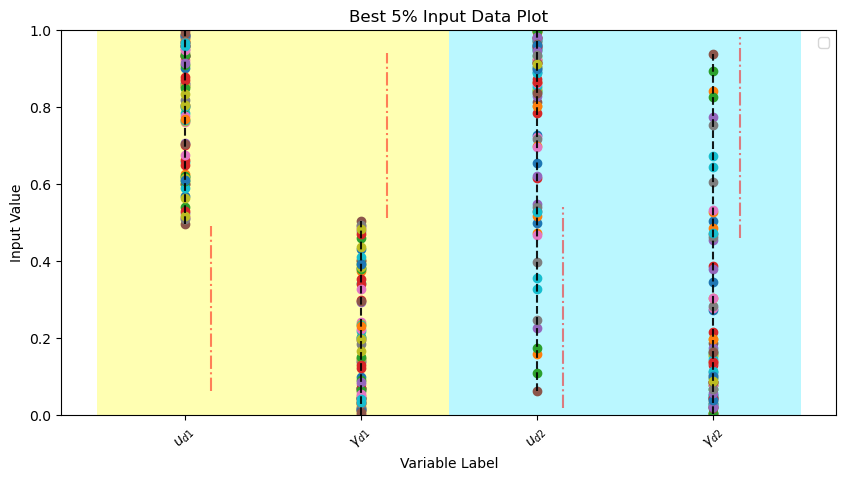

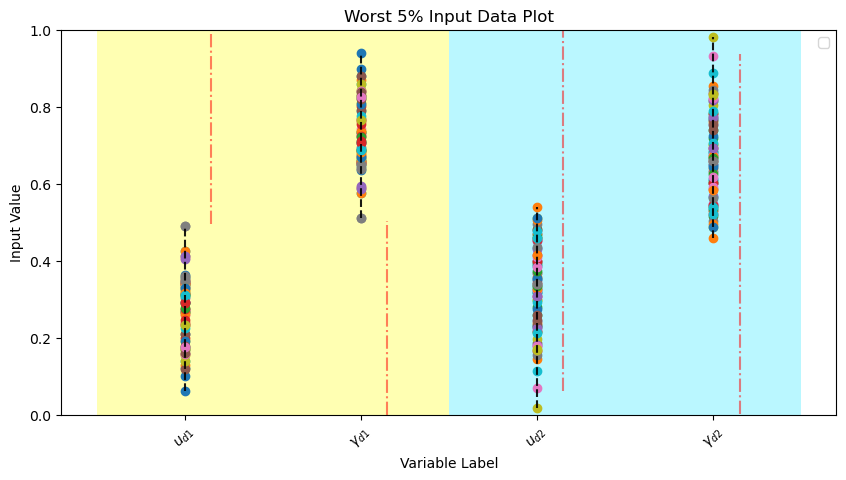

In [48]:
otaf.plotting.plot_best_worst_results(best_5p_res, worst_5p_res, figsize=(10,5))

variable_labels = [var for var in lambda_sample_conditioned.getDescription()]
otaf.plotting.plot_best_worst_input_data(best_5p_lambda, worst_5p_lambda, variable_labels, figsize=(10,5), labels=False)

# Using the score function aproach on the neural surrogate.

In [ ]:
N_SAMPLE_MINI = int(1e6)
standards = [RandDeviationVect.getParameter()[i] for i , param in enumerate(RandDeviationVect.getParameterDescription()) if "sigma" in param] 
means = [RandDeviationVect.getParameter()[i] for i , param in enumerate(RandDeviationVect.getParameterDescription()) if "mu" in param] 
sample = np.array(RandDeviationVect.getSample(N_SAMPLE_MINI))
threshold = 0 
def model(x):
    return np.squeeze(neural_model.evaluate_model_non_standard_space(x).detach().numpy())

def optimization_function_maxi(x): 
    res = otaf.uncertainty.monte_carlo_non_compliancy_rate_w_gradient(
        threshold, sample, means, standards, model)(x)
    return res[0], res[1]

def optimization_function_mini(x): 
    res = otaf.uncertainty.monte_carlo_non_compliancy_rate_w_gradient(
        threshold, sample, means, standards, model)(x)
    return -1*res[0], -1*res[1]


In [ ]:
cons, linearConstraint = otaf.uncertainty.lambda_constraint_dict_from_composed_distribution(RandDeviationVect)
bounds_lambda = otaf.uncertainty.bounds_from_composed_distribution(RandDeviationVect)

In [ ]:
optimization_function_maxi([0,1, 0, 1876])

In [ ]:
res = minimize(optimization_function_maxi,[1,1,1,1], 
         jac=True, method="SLSQP", 
         options={"disp":True, "maxiter":100, "ftol":1e-9},      
         bounds=bounds_lambda, constraints=cons, callback=print_callback)

display(res)

In [ ]:
res = minimize(optimization_function_mini,[0.8,0.2,0.8,0.2], 
         jac=True, method="SLSQP", 
         options={"disp":True, "maxiter":100, "ftol":1e-8,"finite_diff_rel_step":0.1, "eps":1e-6},
         bounds=bounds_lambda, constraints=cons, callback=print_callback)

display(res)